# Transfer Matrix Calculations

### initial stuff

import necessary pacakges 

if this is used in a paper cite Steven J. Brynes (creator of tmm package) arxiv paper: https://arxiv.org/pdf/1603.02720.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import trapz

#ColorPy package allows you to convert a spectrum into a color you would see
#downloaded from Github https://github.com/fish2000/ColorPy 
#note that PyPI version is only compatible with Python 2 - Github is compatible with 2 & 3
from colorpy import colormodels, illuminants 

#TMM package does all transfer matrix calculations
#installed from PyPI
from tmm import coh_tmm, absorp_in_each_layer, color, position_resolved

define plot style

In [2]:
%config InlineBackend.figure_format = 'retina' #to make inline images higher res
plt.style.use(['presplot_small']) #this is a plot format that I have in my style folder on my computer
#plt.rcParams["figure.figsize"] = [8,8]

define constants & load AM1.5

In [3]:
q=1.602e-19
c=2.998e8
h=6.626e-34

am1p5_raw=np.loadtxt('am1p5.txt')

load nk data - as a dictionary with the different materials as items, arrays are lambda (microns), n, k

In [4]:
nkdata_raw = np.load('nkdata_raw.npy',allow_pickle='TRUE').item()
print(nkdata_raw.keys())

dict_keys(['Ag_raw', 'Al_raw', 'Au_raw', 'ITO_raw', 'In_raw', 'MoS_2_raw', 'MoSe_2_raw', 'PDMS_raw', 'Pd_raw', 'Pt_raw', 'SiO_2_raw', 'Si_raw', 'WS_2_raw', 'WSe_2_raw', 'monoWS_2_raw', 'TiO_2_raw', 'SnO_2_raw', 'PEDOT_raw', 'TCTA_raw', 'MoO_3_raw', 'NiO_x_raw', 'Spiro_raw', 'WO_3_raw', 'ZnO_raw'])


## calculate absorbtion in each layer of a stack

### > input parameters here <
initialize stack parameters

In [5]:
# list of materials in stack
mat_list=np.array(["Au","MoO_3","MoSe_2","TiO_2","Ag","Si"])

# list of layer thicknesses in nm, start and end with inf
d_list = np.array([np.inf,20,10,20,10,100,1000,np.inf])

# list of wavelengths
ldas=np.arange(350,900,1) 

#polarization
pol="s"

#angle
theta=0;

In [6]:
#find which layer TMD is in
true_array=np.logical_or(np.logical_or(mat_list=="MoS_2",mat_list=='MoSe_2'),
              np.logical_or(mat_list=='WS_2',mat_list=='WSe_2'))

tmd_index=np.argwhere(true_array==True)[0][0]

### transfer matrix stuff

interpolate nk data

In [7]:
nkdata={}
for mat in mat_list:
    raw=nkdata_raw[mat+"_raw"]
    n_raw=interp1d(raw[:,0],raw[:,1],fill_value="extrapolate")
    k_raw=interp1d(raw[:,0],raw[:,2],fill_value="extrapolate")
    n=n_raw(ldas/1000)
    k=k_raw(ldas/1000)
    nkdata[mat]=np.column_stack((ldas,n,k))

#interpolate am1.5
am1p5_int=interp1d(am1p5_raw[:,0],am1p5_raw[:,1],fill_value="extrapolate")
am1p5=am1p5_int(ldas)

actual transfer matrix calculation

In [8]:
#initialize all matrices
R=np.zeros(np.size(ldas))
T=np.zeros(np.size(ldas))
A=np.zeros(np.size(ldas))
a_layer=np.zeros((np.size(ldas),np.size(mat_list)))

#loop over all wavelengths
i=0
for lda in ldas:    
    
    #initialize n_list, index
    n_list=np.ones(np.size(d_list),dtype=complex)
    j=0
    
    #calculate n,k at this wavelength for each material, populate n_list
    for mat in mat_list:
        j+=1
        nk=nkdata[mat]
        n_list[j]=nk[i,1]+nk[i,2]*1j
        
    #TMM
    coh_tmm_data=coh_tmm(pol,n_list,d_list,theta,lda)
    
    #absorption in each layer
    a=absorp_in_each_layer(coh_tmm_data)
    
    #add to arrays 
    R[i]=coh_tmm_data["R"]
    T[i]=coh_tmm_data["T"]
    A[i]=1-coh_tmm_data["R"]-coh_tmm_data["T"]
    a_layer[i,:]=a[1:np.size(mat_list)+1]

    i+=1

#calculate jsc
integrand=am1p5*a_layer[:,tmd_index]*q/(h*c)*ldas*1e-9
jsc=trapz(integrand,ldas)/10
jsc

9.714133298012072

### plots

plot absorption in all layers

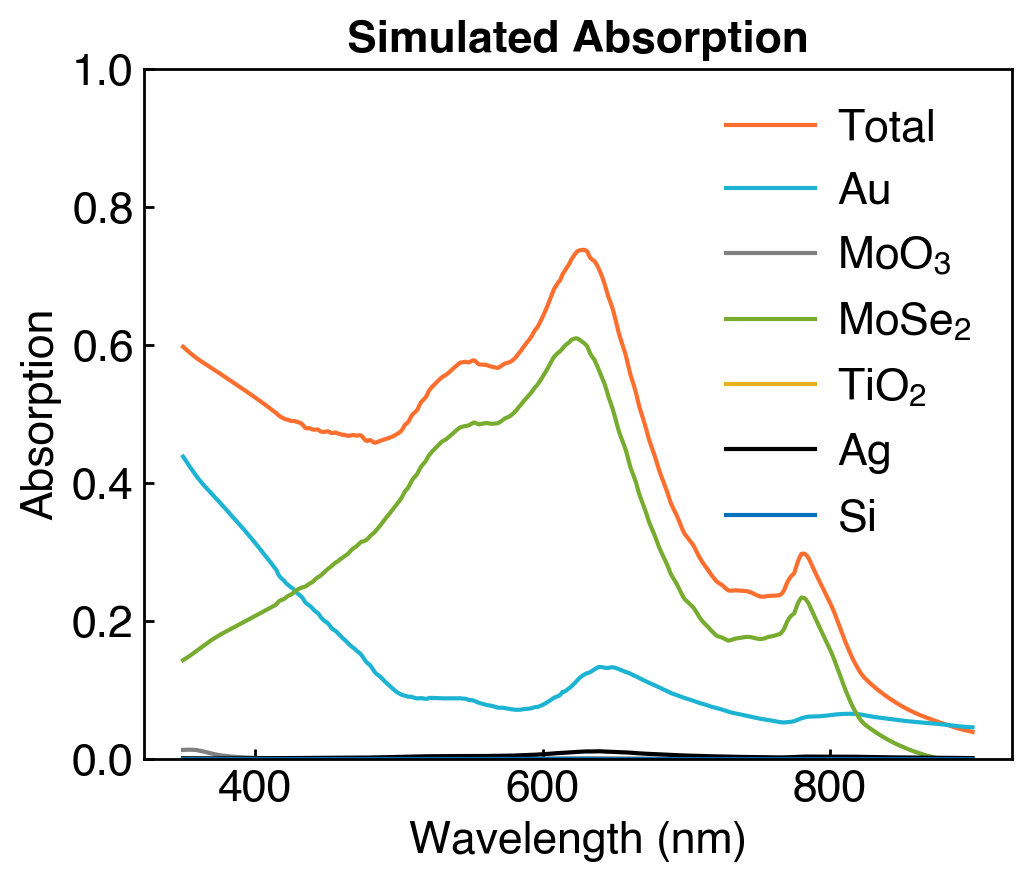

In [9]:
fig,ax=plt.subplots()
ax.plot(ldas,np.sum(a_layer,axis=1),label="Total")  
for i in np.arange(0,np.size(mat_list),1):
    ax.plot(ldas,a_layer[:,i],label="$"+mat_list[i]+"$")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorption")
ax.legend(loc="upper right")
ax.set_title('Simulated Absorption')
#ax.set_xlim([450,750])
ax.set_ylim([0,1])
fig.savefig('cscs/20-10-20-10-100_Au-MoO3-MoSe2_TiO2-Ag_Jsc9p7.pdf')

## color from spectrum calculation

determine color of exfoliated flake

### > input parameters here <

In [10]:
color_mat_list=np.array(["MoSe_2","TiO_2","Ag","Si"])
color_d_list=np.array([np.inf,0,10,100,1000,np.inf]) #thicknesses in nm
thickness_list=np.arange(0,50,1)

create list of indices of refraction

In [11]:
air_n_fn = lambda wavelength : 1
n_fn_list=[air_n_fn]

for mat in color_mat_list:
    raw=nkdata_raw[mat+"_raw"]
    mat_n_fn=interp1d(raw[:,0]*1000,raw[:,1]+raw[:,2]*1j,fill_value="extrapolate")
    n_fn_list.append(mat_n_fn)
n_fn_list.append(air_n_fn)

calculate color for all thicknesses in color_d_list

In [12]:
irgb_list=[]
r_list=[]
max_thickness=thickness_list[len(thickness_list)-1]

index=1
for t in thickness_list:
    color_d_list[index]=t

    reflectances = color.calc_reflectances(n_fn_list, color_d_list, theta)
    illuminant = illuminants.get_illuminant_D65()
    spectrum = color.calc_spectrum(reflectances, illuminant)
    color_dict = color.calc_color(spectrum)
    color_string = colormodels.irgb_string_from_irgb(color_dict["irgb"])
    
    irgb_list.append(color_string)
    r_list.append(reflectances)

plot range of colors for different TMD thicknesses (adopeted from TMM package example file)

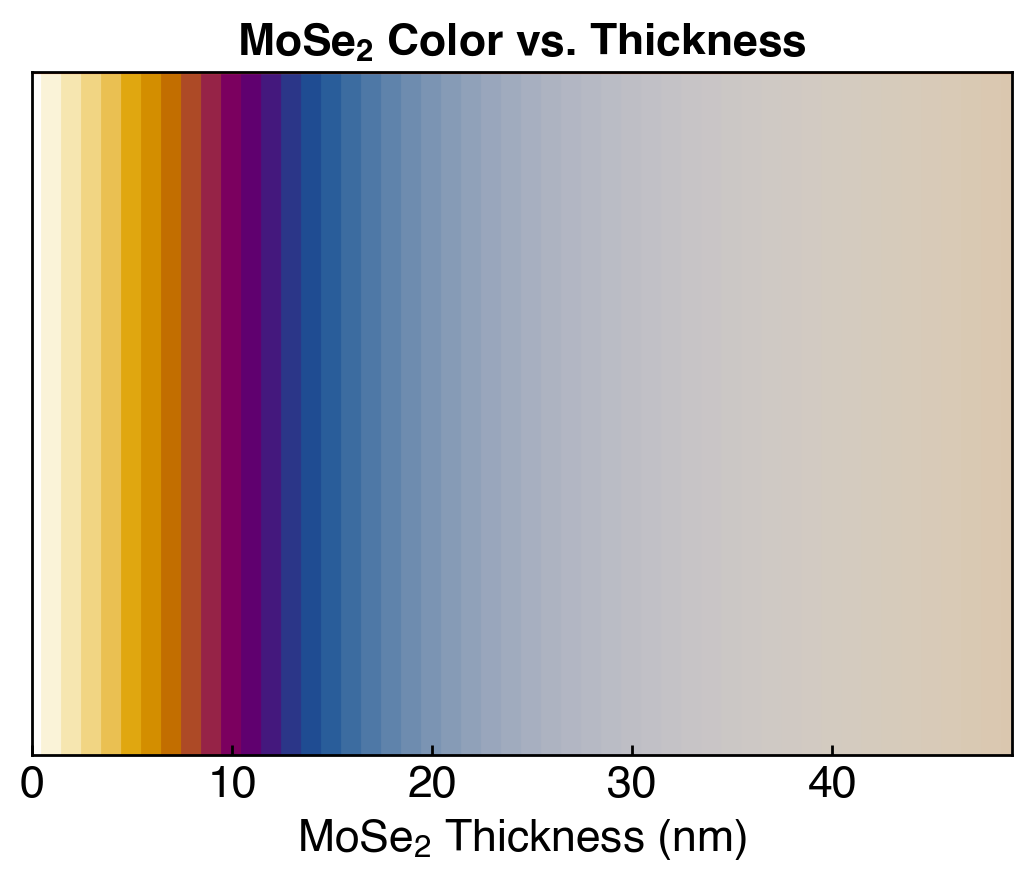

In [13]:
fig=plt.figure()
plt.plot([0,max_thickness],[1,1])
plt.xlim(0,max_thickness)
plt.ylim(0,1)
plt.xlabel('$'+str(color_mat_list[0])+'$ Thickness (nm)')
plt.yticks([])
plt.title('$'+str(color_mat_list[0])+'$ Color vs. Thickness')

for i in range(len(thickness_list)):
    # One strip of each color, centered at x=thickness_list[i]
    if i==0:
        x0 = 0
    else:
        x0 = (thickness_list[i] + thickness_list[i-1]) / 2
    if i == len(thickness_list) - 1:
        x1 = max_thickness
    else:
        x1 = (thickness_list[i] + thickness_list[i+1]) / 2
    y0 = 0
    y1 = 1
    poly_x = [x0,  x1,  x1, x0]
    poly_y = [y0, y0, y1, y1]
    color_string = irgb_list[i]
    plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)
    
fig.savefig('cscs/mose2-color-tio2-10nm.png')

plot reflectance, apparent color is in background, with thickness=t_plot

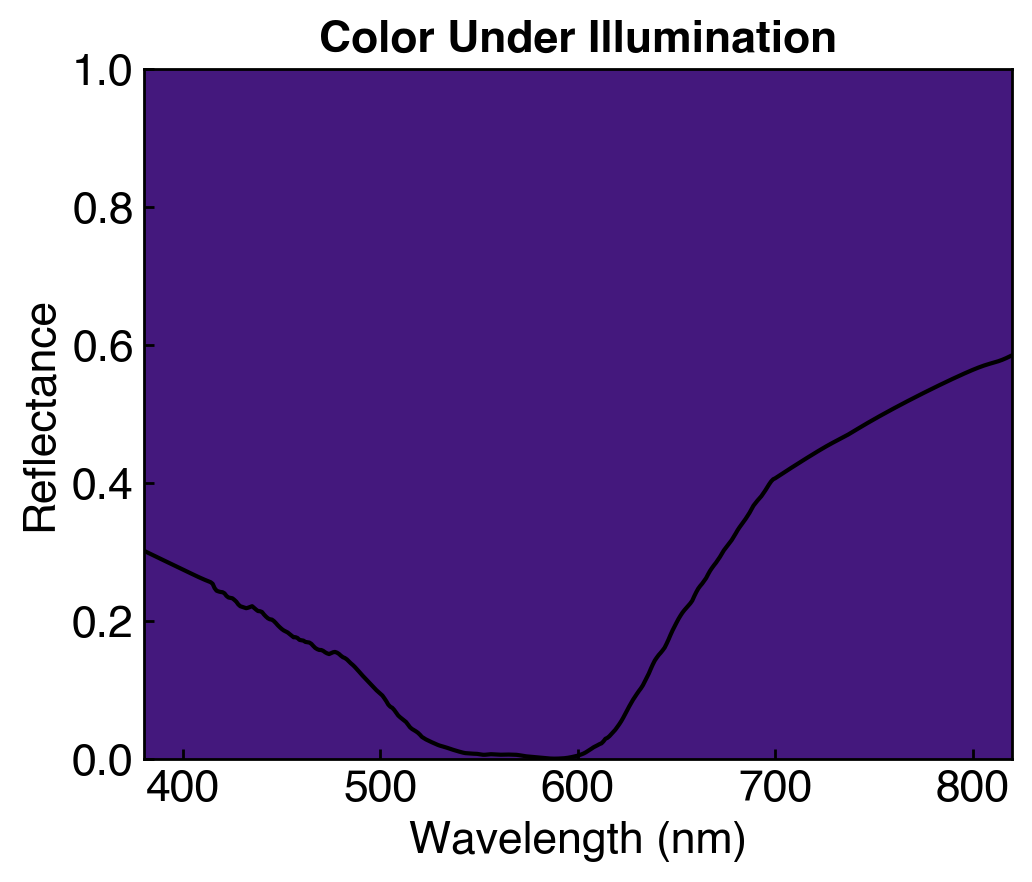

In [16]:
t_plot=12
i_plot=np.where(thickness_list==t_plot)[0][0]

fig,ax=plt.subplots()

ax.plot(r_list[i_plot][:,0],r_list[i_plot][:,1],'black')    
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Reflectance")
ax.set_title('Color Under Illumination')
ax.set_xlim([380,820])
ax.set_ylim([0,1])
ax.set_facecolor(irgb_list[i_plot])